### 1-4 时间序列数据建模流程范例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import losses, metrics, callbacks

(array([ 0., 10., 20., 30., 40., 50.]), <a list of 6 Text xticklabel objects>)

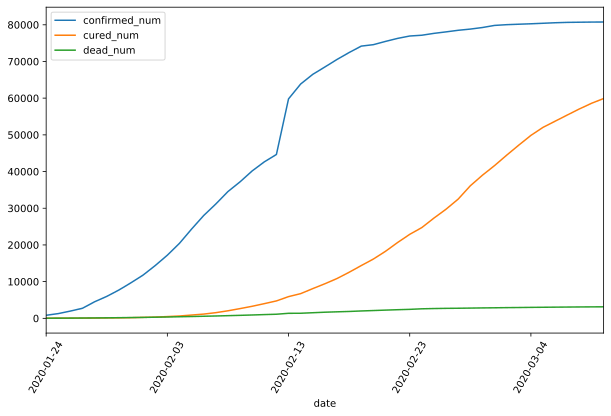

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("../data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)

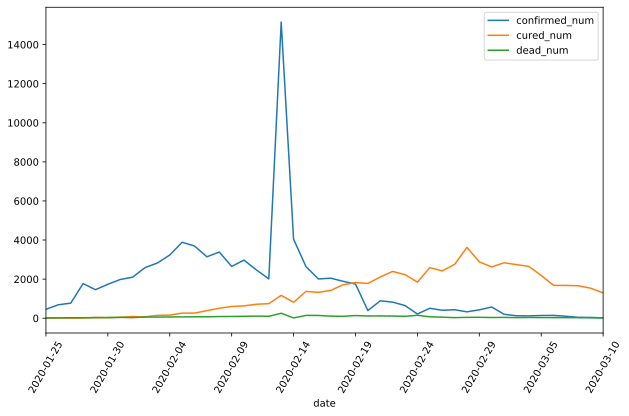

In [5]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [6]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

#### 定义模型

In [7]:
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
        
    def call(self, x_input, x):
        x_out = tf.maximum((1+x)*x_input[:, -1, :], 0.0)
        return x_out
    
    def get_config(self):
        config = super(Block, self).get_config()
        return config 

In [12]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

### train

In [13]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self, y_true, y_pred):
        err_percent = (y_true - y_pred) ** 2 / (tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE,self).get_config()
        return config

In [15]:
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=MSPE(name='mspe'))

logdir = '../data/keras_model/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)

#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)

callbacks_list = [tb_callback, lr_callback, stop_callback]
history = model.fit(ds_train, epochs=1000,callbacks = callbacks_list)

Epoch 1/1000
1/1 [==============================] - 8s 8s/step - loss: 0.4282
Epoch 2/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.4294
Epoch 3/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.4287
Epoch 4/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.4290
Epoch 5/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.4281
Epoch 6/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.4283
Epoch 7/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.4284
Epoch 8/1000
1/1 [==============================] - 0s 111ms/step - loss: 0.4280
Epoch 9/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.4278
Epoch 10/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.4279
Epoch 11/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.4263
Epoch 12/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.4248
Epoch 13/1000
1/1 [===================

1/1 [==============================] - 0s 111ms/step - loss: 0.3066
Epoch 103/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.3064
Epoch 104/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.3063
Epoch 105/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.3061
Epoch 106/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.3060
Epoch 107/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.3058
Epoch 108/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.3057
Epoch 109/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.3055
Epoch 110/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.3054
Epoch 111/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3052
Epoch 112/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.3051
Epoch 113/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.3049
Epoch 114/1000
1/1 [==========

1/1 [==============================] - 0s 87ms/step - loss: 0.2933
Epoch 203/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.2932
Epoch 204/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.2931
Epoch 205/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.2930
Epoch 206/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.2929
Epoch 207/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.2928
Epoch 208/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.2927
Epoch 209/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2926
Epoch 210/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.2926
Epoch 211/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.2925
Epoch 212/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.2924
Epoch 213/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.2923
Epoch 214/1000
1/1 [===========

Epoch 303/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.2892
Epoch 304/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.2892
Epoch 305/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2892
Epoch 306/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.2892
Epoch 307/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.2892
Epoch 308/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.2891
Epoch 309/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2891
Epoch 310/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2891
Epoch 311/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.2891
Epoch 312/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.2891
Epoch 313/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.2891
Epoch 314/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.2891
Epoch 315/1000
1

Epoch 403/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.2879
Epoch 404/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.2879
Epoch 405/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.2879
Epoch 406/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.2879
Epoch 407/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.2879
Epoch 408/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.2878
Epoch 409/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.2878
Epoch 410/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.2878
Epoch 411/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.2878
Epoch 412/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.2878
Epoch 413/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.2878
Epoch 414/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.2878
Epoch 415/1000
1

Epoch 503/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.2874
Epoch 504/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.2874
Epoch 505/1000
1/1 [==============================] - 0s 112ms/step - loss: 0.2874
Epoch 506/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.2874
Epoch 507/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.2874
Epoch 508/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.2874
Epoch 509/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.2874
Epoch 510/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.2874
Epoch 511/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2874
Epoch 512/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.2873
Epoch 513/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.2873
Epoch 514/1000
1/1 [==============================] - 0s 142ms/step - loss: 0.2874
Epoch 515/1000

Epoch 603/1000
1/1 [==============================] - 0s 127ms/step - loss: 0.2873
Epoch 604/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.2872
Epoch 605/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.2871
Epoch 606/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.2872
Epoch 607/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.2873
Epoch 608/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.2873
Epoch 609/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.2872
Epoch 610/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.2871
Epoch 611/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.2872
Epoch 612/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.2872
Epoch 613/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.2872
Epoch 614/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.2872
Epoch 615/100

Epoch 703/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.2873
Epoch 704/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.2873
Epoch 705/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.2873
Epoch 706/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.2872
Epoch 707/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.2871
Epoch 708/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.2871
Epoch 709/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.2870
Epoch 710/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.2870
Epoch 711/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.2871
Epoch 712/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.2871
Epoch 713/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.2871
Epoch 714/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.2871
Epoch 715/1000
1

Epoch 803/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2870
Epoch 804/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2870
Epoch 805/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2870
Epoch 806/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2870
Epoch 807/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2870
Epoch 808/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2870
Epoch 809/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.2870
Epoch 810/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2870
Epoch 811/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.2870
Epoch 812/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.2870
Epoch 813/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.2870
Epoch 814/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.2870
Epoch 815/1000
1

Epoch 903/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.2869
Epoch 904/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.2869
Epoch 905/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.2869
Epoch 906/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.2869
Epoch 907/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.2869
Epoch 908/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.2869
Epoch 909/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.2869
Epoch 910/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.2869
Epoch 911/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.2869
Epoch 912/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.2869
Epoch 913/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.2869
Epoch 914/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.2869
Epoch 915/1000

### evaluate

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

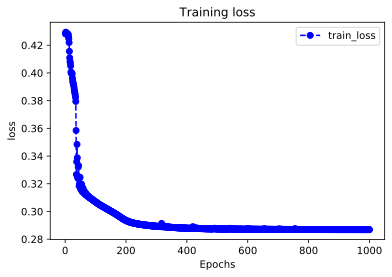

In [17]:
plot_metric(history, 'loss')

In [18]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [19]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [24]:
dfresult.query('confirmed_num==0').head()

,confirmed_num,cured_num,dead_num
47,0.0,1382.0,24.0
48,-0.0,1629.0,26.0
49,-0.0,1779.0,27.0
50,-0.0,1826.0,22.0
51,-0.0,1929.0,16.0


In [25]:
# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

In [30]:
dfresult.query('cured_num < 10').head()

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
126,-0.0,9.0,0.0
127,-0.0,8.0,0.0


### 保存模型并重加载

In [31]:
model.save('../data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

W0412 10:24:17.007693 4520799680 deprecation.py:506] From /Users/ting/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


export saved model.


In [32]:
model_loaded = tf.keras.models.load_model('../data/tf_model_savedmodel/', compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer, loss=MSPE(name='mspe'))
model_loaded.predict(ds_train)

array([[1.0636194e+03, 9.2656075e+01, 3.2971358e+00],
       [1.3119155e+03, 7.2650787e+01, 6.7041759e+00],
       [1.4315031e+03, 1.5477777e+02, 6.2645578e+00],
       [1.6382476e+03, 1.6530687e+02, 7.0338898e+00],
       [1.9691401e+03, 2.7375659e+02, 7.1437941e+00],
       [1.8718486e+03, 2.7480951e+02, 8.0230303e+00],
       [1.5926421e+03, 4.0747617e+02, 8.0230303e+00],
       [1.7152700e+03, 5.3698407e+02, 9.4517899e+00],
       [1.3438394e+03, 6.3069305e+02, 9.7815027e+00],
       [1.5064987e+03, 6.6543909e+02, 1.0660739e+01],
       [1.2500948e+03, 7.5283063e+02, 1.1869689e+01],
       [1.0210544e+03, 7.8336499e+02, 1.0660739e+01],
       [7.6774170e+03, 1.2329575e+03, 2.7915751e+01],
       [2.0507231e+03, 8.5496289e+02, 1.4287589e+00],
       [1.3382654e+03, 1.4456454e+03, 1.5716348e+01],
       [1.0175073e+03, 1.3929999e+03, 1.5606443e+01],
       [1.0377764e+03, 1.5003967e+03, 1.1539975e+01],
       [9.5670007e+02, 1.7983702e+03, 1.0770643e+01],
       [8.8626508e+02, 1.920